## Решение тестового задания
--------

Ноутбук устроен следующим образом:

1. Анализ данных и подготовка текста
2. Классификациия текста с помощью классических методов машинного обучения и метода векторизации текста TF-IDF
3. Классификация текста с помощью LSTM
4. Классификация текста с помощью предобученной на данных русскоязычных твитов модели BERT


> Предлается сменить среду в Google Colab с CPU на GPU


Гасанов Михаил, 2023

In [1]:
!pip -q install pymorphy2
!pip3 -q install sentencepiece
!pip3 -q install transformers

!wget -q https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_classifier.py
!wget -q https://raw.githubusercontent.com/shitkov/bert4classification/main/bert_dataset.py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 74.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.1 MB/s eta 0:00:00


In [2]:
# general
import pandas as pd
import numpy as np

# nlp
import nltk
import string
import re
import codecs
import pymorphy2

# plot
import seaborn as sns
import matplotlib.pyplot as plt

# models
import sklearn

## 1. 📈 Анализ данных и подготовка текста
-------

На этот этапе мы проведем разведочный анализ текстов и первичную подготовку текста

In [3]:
# Read initial csv file 'train.csv' from
url='https://drive.google.com/file/d/1r-pmgdpl8KDEmtC0KcU2O_27Js212v3G/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

In [4]:
# decode labels for plotting
human_name = {0:'Python chat', 1: 'DS chat'}
df['label_name'] = df['label'].apply(lambda x: human_name[x])

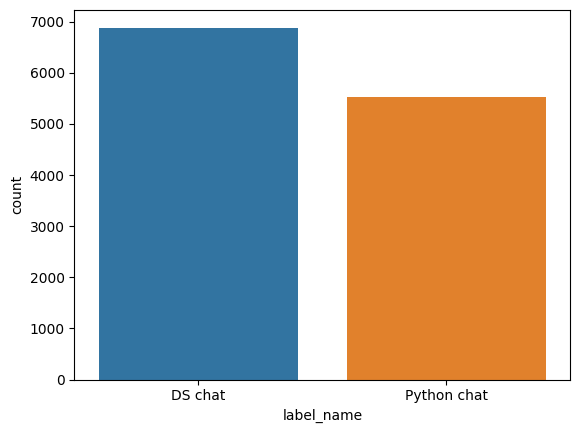

In [5]:
x=df.groupby('label_name', as_index=False).count()
sns.countplot(x=df['label_name'])
plt.show()

In [6]:
# Remove partly messages from DS to equal class balance
ds_chat = df[df['label_name']=='DS chat']
python_chat = df[df['label_name']=='Python chat']
ds_chat = ds_chat.sample(n=len(python_chat), random_state=101)
df = pd.concat([python_chat,ds_chat],axis=0)

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

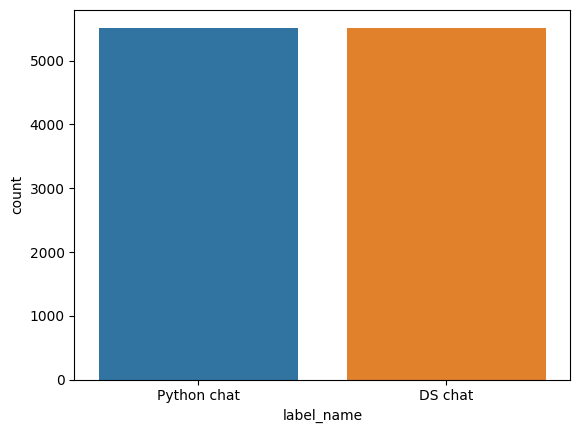

In [8]:
x=df.groupby('label_name', as_index=False).count()

sns.countplot(x=df['label_name'])
plt.show()

Визуализация распределений сообщений длинной больше 100 слов

<Axes: xlabel='len', ylabel='Density'>

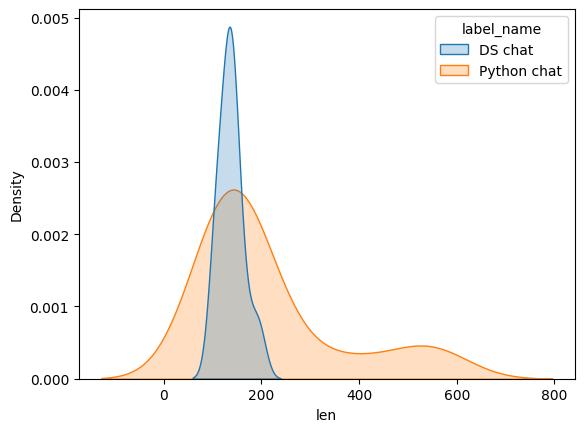

In [9]:
df['len'] = df['text'].apply(lambda x: len(x.split(' ')))

max_words = df['len'].max()

mask = df['len']>100

sns.kdeplot(x='len',
            hue='label_name',
            fill=True,
            data=df.loc[mask] )

In [10]:
# кажется что иногда в чат по Python отправляют куски кода или ошибки.
# стоит отметить, что таких сообщений не очень много
# и можно попробовать обрезать сообщения по первым 100-120 словам
print(len(df.loc[mask]))
df.loc[mask].head(15)

35


,text,label,label_name,len
73,"ну вот я занимаюсь построением скормоделей, мн...",1,DS chat,135
218,"import npyscreen, vk_api\nglobal vk_auth, vk, ...",0,Python chat,170
517,ubuntu lates...,0,Python chat,136
549,В рамках программы это выглядит так:\nwith ope...,0,Python chat,139
1142,"надо.\n\n– Вот и все,– громко сказал кто-то в ...",1,DS chat,148
1379,"man systemd-journald\nBy default, the journal ...",0,Python chat,105
1529,Ну по факту для самого Мегафона как для условн...,1,DS chat,139
1530,The INI file format has severe restrictions on...,0,Python chat,133
1797,сегодня пока ехал на работу слышал байку про К...,1,DS chat,133
2398,"Это может быть не столько инновацией, сколько ...",1,DS chat,108


### 1.2 Очиста и подготовка текста
-----

Что будем делать?

Приводить к нижнему решистру, удалять символы (`[, :, ...`) и стоп-слова, а также проведем лемматизацию - то есть приведем слова в тексте к их нормальной форме

In [11]:
# download stopwords for nltk package
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
# create set for russian stopwords
from nltk.corpus import stopwords
stopWords = set(stopwords.words('russian'))

In [13]:
# list of symbols to remove from text
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”"]

In [14]:
# for lema we will utilize pymorphy2
# Docs - https://pymorphy2.readthedocs.io/en/stable/
morph = pymorphy2.MorphAnalyzer()

In [15]:
def str_preprocess(text: str)->list:
    """
    Function to clean text and create lemmas
    """
    reg = re.compile('[^а-яА-яa-zA-Z0-9 ]') #
    text = text.lower().replace("ё", "е")
    text = text.replace("ъ", "ь")
    text = text.replace("й", "и")
    text = text.replace("\\n", "")
    text = text.replace("\\r", "")
    text = text.replace("\\t", "")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'сайт', text)
    text = re.sub('@[^\s]+', 'пользователь', text)
    text = reg.sub(' ', text)

    # Лемматизация
    text =  " ".join([word for word in text.split() if word not in SYMBOLS])
    text =[morph.parse(word)[0].normal_form for word in text.split() if word not in stopWords]
    return ' '.join(text)

In [16]:
from tqdm import tqdm
tqdm.pandas()

In [17]:
# apply function of text cleaning
df['clean_text'] = df.progress_apply(lambda x : str_preprocess(x.text), axis=1)

100%|██████████| 11038/11038 [00:18<00:00, 597.74it/s]


In [18]:
df.head()

,text,label,label_name,len,clean_text
0,"ну, мб он не робот, а живой чувак, ходящий по ...",0,Python chat,11,мб робот живой чувак ходящие чат
1,"Если это продукт какой-то, то все равно придет...",1,DS chat,12,это продукт какой равно прийтись какой стадия ...
2,Перемешиваешь? В смысле какой-то шум к ней док...,1,DS chat,14,перемешивать смысл какой шум нея докинуть иной...
3,1. Поменять первый слой\n2. Засунуть трехканал...,1,DS chat,10,1 поменять первыя слои2 засунуть трехканальный...
4,"Сомневаюсь\nКак бы ты назвал вакансию, где над...",1,DS chat,16,сомневаюськак назвать вакансия просто шарить м...


In [19]:
df.to_csv('dataset.csv')

## 🔮 2. Классификациия текста с помощью классических методов машинного обучения

-----

Для обучения будем пробовать основные модели машинного обучения, в качестве метрик предлагается использовать `accuracy` и `f1-score`

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [31]:
df = pd.read_csv('./dataset.csv', index_col = 0)

In [32]:
# Оставим только данные для обучения
df['text'] = df['clean_text']
df=df[['text', 'label']]

### 2.1 Test/Train splitting

In [33]:
# Remove messages with len less than 100 words
df['text'] = df['text'].astype(str)
mask = df['text'].str.split().apply(lambda x: len(x))<100
df = df.loc[mask]
mask = df['text'].str.split().apply(lambda x: len(x))>5
df = df.loc[mask]

In [34]:
test_size = 0.3

X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['label'],
                                                    test_size=test_size,
                                                    random_state=42)


### 2.2  Bag of Words text representation

In [35]:
vectorizer = CountVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)

In [36]:
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1351
           1       0.80      0.76      0.78      1299

    accuracy                           0.79      2650
   macro avg       0.79      0.79      0.79      2650
weighted avg       0.79      0.79      0.79      2650



In [37]:
def plot_confusion(y_test, y_pred):
    dict_normal_names={0: "Python",1:"DS"}
    data = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(data, columns=list(map(dict_normal_names.get, list(np.unique(y_test)))),
                                index = list(map(dict_normal_names.get, list(np.unique(y_test)))))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    #confusion matrix plot
    f, ax = plt.subplots(figsize=(4, 5))
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)

    sns.heatmap(df_cm, cbar=False, annot=True, cmap=cmap, square=True, fmt='.0f',
                annot_kws={'size': 10})
    plt.title('Actuals vs Predicted')
    plt.show()

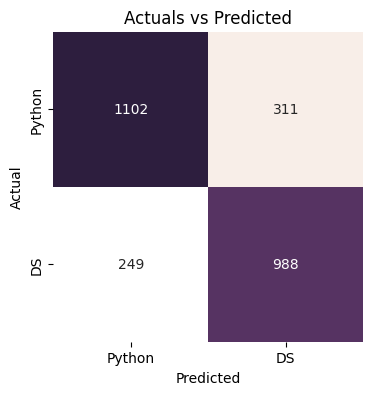

In [38]:
plot_confusion(y_test, y_pred)

### 2.3 TF-IDF text representation

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)

In [40]:
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1397
           1       0.78      0.77      0.77      1253

    accuracy                           0.79      2650
   macro avg       0.79      0.79      0.79      2650
weighted avg       0.79      0.79      0.79      2650



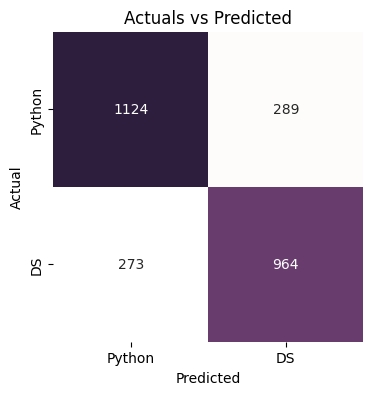

In [41]:
plot_confusion(y_test, y_pred)

### 2.4 Сравнение различных моделей для метода TF-IDF

In [42]:
def get_models():
    return {'RandomForest': RandomForestClassifier(bootstrap=True,
                                                   n_estimators=100,
                                                   n_jobs=-1),
           "GB":GradientBoostingClassifier(n_estimators=100),
            "kNN":KNeighborsClassifier(),
            "LogisticRegression":LogisticRegression(),
            "SVC":SVC(kernel='rbf')}



In [47]:

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

X_train_TFIDF = vectorizer.fit_transform(X_train)
X_test_TFIDF = vectorizer.transform(X_test)

metrics = {}
models = get_models()
for name, model in models.items():
    print(name)
    clf = model.fit(X_train_TFIDF, y_train)
    y_predict_TFIDF = clf.predict(X_test_TFIDF)
    score = f1_score(y_predict_TFIDF, y_test)
    metrics[name] = score


RandomForest
GB
kNN
LogisticRegression
SVC


In [50]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index').reset_index()
df_metrics.columns = ['model', 'f1_score']

In [51]:
df_metrics

,model,f1_score
0,RandomForest,0.741379
1,GB,0.722455
2,kNN,0.724486
3,LogisticRegression,0.774297
4,SVC,0.778084


Из сравнения моделей можно сделать предположение что варианты на решающих деревьях работают хуже

Сохраним логистическую моделя для работы

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_coded = vectorizer.fit_transform(X_train)
X_test_coded = vectorizer.transform(X_test)
clf = LogisticRegression(random_state=0).fit(X_train_coded, y_train)
y_pred = clf.predict(X_test_coded)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1397
           1       0.78      0.77      0.77      1253

    accuracy                           0.79      2650
   macro avg       0.79      0.79      0.79      2650
weighted avg       0.79      0.79      0.79      2650



In [53]:
# Save model for future API
from joblib import dump, load
dump(clf, './logistic_reg_model.joblib')

['./logistic_reg_model.joblib']

In [54]:
# Save vectorizer for future API
dump(vectorizer, 'vectorizer_tfidf.pkl', compress=True)

['vectorizer_tfidf.pkl']

### 2.5 📍Пример неудачного решения

-------

Была попытка использовать пакет SpyCy и его реализацию для русского языка

Однако возникли проблемы с лемматизацией слов с использованием русского корпуса слов

In [55]:
import string
import spacy
from spacy.lang.ru.stop_words import STOP_WORDS
from spacy.lang.ru import Russian

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
# nlp = spacy.load('ru2_combined_400ks_96')
stop_words = spacy.lang.ru.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = Russian()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase


    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = [ morph.parse(word)[0].normal_form.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    # mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

## 3. 💡 Классификация текста с помощью LSTM


In [56]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

In [57]:
df['text'] = df['text'].astype(str)

In [111]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label'],
                                                    test_size=0.25, random_state=434)


In [142]:
# Defining pre-processing parameters
max_len = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 1500

In [143]:
tokenizer = Tokenizer(num_words = vocab_size,
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(x_train)

In [144]:
# Get the word_index
word_index = tokenizer.word_index
total_words = len(word_index)
total_words

15632

In [145]:
training_sequences = tokenizer.texts_to_sequences(x_train)
training_padded = pad_sequences(training_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)
testing_sequences = tokenizer.texts_to_sequences(x_test)
testing_padded = pad_sequences(testing_sequences,
                               maxlen = max_len,
                               padding = padding_type,
                               truncating = trunc_type)

print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (6623, 100)
Shape of testing tensor:  (2208, 100)


In [146]:
# Define parameter
embedding_dim = 32 # size for embeding of word
n_dense = 24# Define Dense Model Architecture
n_lstm = 64
drop_lstm = 0.1# Define LSTM Model

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(SpatialDropout1D(drop_lstm))
model.add(LSTM(n_lstm, return_sequences=False))
model.add(Dropout(drop_lstm))
model.add(Dense(1, activation='sigmoid'))

In [147]:
model.compile(loss = 'binary_crossentropy',
               optimizer = 'adam',
               metrics = ['accuracy'])

In [148]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded,
                    y_train,
                    epochs=num_epochs,
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/30
207/207 - 18s - loss: 0.6927 - accuracy: 0.5183 - val_loss: 0.6938 - val_accuracy: 0.5072 - 18s/epoch - 87ms/step
Epoch 2/30
207/207 - 3s - loss: 0.6926 - accuracy: 0.5227 - val_loss: 0.6938 - val_accuracy: 0.5072 - 3s/epoch - 16ms/step
Epoch 3/30
207/207 - 2s - loss: 0.6925 - accuracy: 0.5227 - val_loss: 0.6934 - val_accuracy: 0.5072 - 2s/epoch - 10ms/step
Epoch 4/30
207/207 - 3s - loss: 0.6925 - accuracy: 0.5227 - val_loss: 0.6931 - val_accuracy: 0.5072 - 3s/epoch - 13ms/step
Epoch 5/30
207/207 - 2s - loss: 0.6923 - accuracy: 0.5230 - val_loss: 0.6931 - val_accuracy: 0.5072 - 2s/epoch - 11ms/step
Epoch 6/30
207/207 - 2s - loss: 0.6923 - accuracy: 0.5227 - val_loss: 0.6939 - val_accuracy: 0.5072 - 2s/epoch - 8ms/step
Epoch 7/30
207/207 - 2s - loss: 0.6922 - accuracy: 0.5227 - val_loss: 0.6933 - val_accuracy: 0.5072 - 2s/epoch - 7ms/step
Epoch 8/30
207/207 - 2s - loss: 0.6924 - accuracy: 0.5224 - val_loss: 0.6935 - val_accuracy: 0.5072 - 2s/epoch - 8ms/step


In [131]:
model.evaluate(testing_padded, y_test)

69/69 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5072


[0.693691074848175, 0.5072463750839233]

In [105]:
# save model to file
model.save('model_lstm.keras')


In [106]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 4. 📺 Классификация текста с помощью предобученной на данных русскоязычных твитов модели BERT
----

Для эксперимента была использована предобученная модель Bert на данных сообщений из русскоязычного твитера

In [149]:
train, test_data = train_test_split(df, test_size=0.2, random_state=1)
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=1)

In [150]:
from bert_dataset import CustomDataset
from bert_classifier import BertClassifier

In [151]:
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny',
        tokenizer_path='cointegrated/rubert-tiny',
        n_classes=2,
        epochs=2,
        model_save_path='/content/bert.pt'
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [152]:
classifier.preparation(
        X_train=list(train_data['text']),
        y_train=list(train_data['label']),
        X_valid=list(valid_data['text']),
        y_valid=list(valid_data['label'])
    )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [153]:
classifier.train()

Epoch 1/2
Train loss 0.7707048083488451 accuracy 0.7149177136789948
Val loss 0.7968452048008469 accuracy 0.7558386411889597
----------
Epoch 2/2
Train loss 0.7265930861881087 accuracy 0.7917182799504512
Val loss 0.8605270789276882 accuracy 0.7657466383581033
----------


In [154]:
texts = list(test_data['text'])
labels = list(test_data['label'])

predictions = [classifier.predict(t) for t in texts]

In [155]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1score = precision_recall_fscore_support(labels,
                                                             predictions,
                                                             average='macro')[:3]

print(f'precision: {precision:.3f}, recall: {recall:.3f}, f1score: {f1score:.3f}')

precision: 0.766, recall: 0.767, f1score: 0.766


## Выводы
----

На основе полученных результатов можно сделать предположение о выборе классической модели машинного обучения и метода TF-IDF для представления текста в векторном пространстве. Предлагает сохранить модель и использовать ее в микросервисе для классификации текста.